In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# MNIST data setup

**`dataset.py`**

In [2]:
from pathlib import Path # Import the Path class from pathlib module
import requests # Import the requests module for making HTTP requests

def myData():
    ### Download Dataset ###
    data_path = Path("data") # Create a Path object for the data directory
    actual_path = data_path/"mnist" # Create a Path object for the mnist subdirectory

    # Create the directory if it does not exist
    actual_path.mkdir(parents=True, exist_ok=True)

    url = "https://github.com/pytorch/tutorials/raw/main/_static/" # The base URL for the dataset
    file_name = "mnist.pkl.gz" # The file name of the dataset

    # Check if the file already exists in the local directory
    if not (actual_path/file_name).exists():
        # If not, download the file from the URL and save it to the local directory
        content = requests.get(url+file_name).content # Get the content of the file as bytes
        (actual_path/file_name).open("wb").write(content) # Open the file in write mode and write the content

    ### Extract Dataset ###
    import pickle # Import the pickle module for loading and saving Python objects
    import gzip # Import the gzip module for working with compressed files

    # Open the compressed file in read mode
    with gzip.open((actual_path/file_name).as_posix(), "rb") as f:
        # Load the pickle object from the file, which contains three tuples: 
        # (x_train,y_train), (x_valid,y_valid), (x_test,y_test)
        ((x_train,y_train),(x_valid,y_valid),_) = pickle.load(file=f, encoding="latin-1")
        # We only need the first two tuples, so we ignore the third one with an underscore

    return (x_train,y_train), (x_valid,y_valid) # Return the two tuples as the output of the function


In [3]:
(x_train,y_train), (x_valid,y_valid) = myData()
print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_valid shape: {x_valid.shape}, y_valid shape: {y_valid.shape}")

x_train shape: (50000, 784), y_train shape: (50000,)
x_valid shape: (10000, 784), y_valid shape: (10000,)


In [4]:
! tree /kaggle
! ls -sh /kaggle/working/data/mnist/

/kaggle
├── input
├── lib
│   └── kaggle
│       └── gcp.py
├── src
│   └── script.ipynb
└── working
    ├── __notebook__.ipynb
    └── data
        └── mnist
            └── mnist.pkl.gz

7 directories, 4 files
total 16M
16M mnist.pkl.gz


# Data Exploration
Each image is 28 x 28, and is being stored as a flattened row of length 784 (=28x28). Let’s take a look at one; we need to reshape it to 2d first.

**`data_exploration.py`**

You have to reshape the **x_train[0]** array to **(28, 28)** because the **imshow()** function expects a 2D array as input for displaying a grayscale image. The x_train[0] array is a 1D array of length 784, which represents a **flattened image of 28 by 28 pixels**. By reshaping it to (28, 28), **you are restoring the original shape of the image and making it compatible with imshow().**

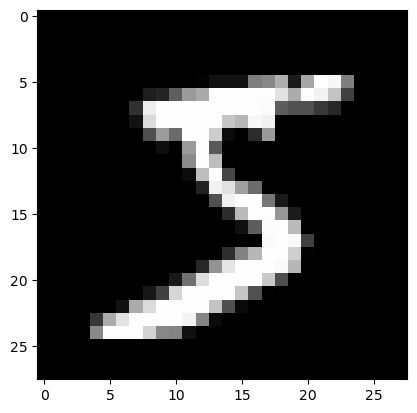

(50000, 784)


In [5]:
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(x_train[0].reshape((28, 28)), cmap="gray")
plt.show()

print(x_train.shape)

# Forward Pass
1. **initialize weights and biases (i.e parameters).**
2. **NN architecture : input ➡️ output (simple architecture with no hidden layer)**
     * **Number of neurons in the Input Layer is (28x28) = 784 and**
     * **Number of neurons in the Output Layer is 10**

**`model.py`**

In [6]:
import torch

In [7]:
# Convert the numpy arrays to tensor
x_train, y_train, x_valid, y_valid = map(torch.tensor, (x_train, y_train, x_valid, y_valid))
x_train, y_train, x_valid, y_valid

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([5, 0, 4,  ..., 8, 4, 8]),
 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([3, 8, 6,  ..., 5, 6, 8]))

1. **initialize weights and biases (i.e parameters).**

**`Xavier Initialization`** is a technique for initializing the weights of a neural network in a way that **preserves the variance of the inputs and outputs of each layer**. The idea is **to avoid having very small or very large values in the weights,** which **can cause vanishing or exploding gradients during training.** Xavier initialization draws the weights from a uniform distribution with a specific range, depending on the number of input and output units of each layer.

In [8]:
import math
torch.manual_seed(0)
weights = torch.randn(784,10,requires_grad=True) / math.sqrt(784) # Xavier Initialization
bias = torch.zeros(10,requires_grad=True) 

2. **NN architecture : input ➡️ output (simple architecture with no hidden layer)**

In [9]:
def model(batched_input):
    return batched_input @ weights + bias

3. **Loss Function**

In [10]:
# softmax activation function
def softmax(x):
    return x.exp()/x.exp().sum(-1).unsqueeze(-1)

print(softmax(model(x_train)))
print()
print(softmax(model(x_train)).shape)

tensor([[0.0536, 0.0503, 0.0946,  ..., 0.1342, 0.0897, 0.1038],
        [0.0529, 0.0615, 0.1341,  ..., 0.1225, 0.0830, 0.0774],
        [0.0952, 0.1340, 0.1113,  ..., 0.1033, 0.0914, 0.0916],
        ...,
        [0.0671, 0.1293, 0.0686,  ..., 0.1668, 0.1060, 0.0906],
        [0.0626, 0.1156, 0.0831,  ..., 0.1021, 0.0638, 0.1103],
        [0.0542, 0.0950, 0.0795,  ..., 0.1658, 0.0540, 0.1028]],
       grad_fn=<DivBackward0>)

torch.Size([50000, 10])


In [11]:
# Cross Entropy Loss
def cross_entropy_loss(preds, targets):
    batch_size, output_features = preds.shape
    one_hot_encode_targets = torch.eye(output_features)[targets]
    # -1/n sum p * log(q) -> n is batch_size : sum everything and take average over the batch
    return -(one_hot_encode_targets * softmax(preds).log()).sum()/batch_size

loss_function = cross_entropy_loss

Test if our implementation of `cross_entropy_loss` is correct or not.

In [12]:
import torch.nn.functional as F

batch_size = 64

batched_x = x_train[:batch_size]
preds = model(batched_x)
batched_y = y_train[:batch_size]

print(f"PyTorch's Function: {F.cross_entropy(preds, batched_y)}")
print(f"My Function: {cross_entropy_loss(preds, batched_y)}")

PyTorch's Function: 2.4608449935913086
My Function: 2.4608447551727295
